In [2]:
%matplotlib inline

# Run all output interactively
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

WORKING_DIR = os.path.dirname(os.getcwd())

In [3]:
wine = pd.read_csv(WORKING_DIR + '/data/raw/winemag-data-130k-v2.csv', index_col = 0)

In [4]:
wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [5]:
wine.describe()
wine.info()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [6]:
There are some duplicated titles. 

SyntaxError: invalid syntax (<ipython-input-6-973f027ea1b8>, line 1)

In [ ]:
wine.duplicated().value_counts()
wine[wine.duplicated(keep=False)].sort_values('title').head(10)
wine = wine.drop_duplicates(keep='first')
wine[wine.duplicated(subset='title', keep=False)].sort_values('title').shape
wine = wine.drop_duplicates(subset='title', keep=False)

In [ ]:
# Extract year from title
## regex to extract date (matching wines from 20th and 21st century)
wine['year'] = wine['title'].apply(lambda x: re.search(r'(19|20)[0-9]{2}', x))  # _sre.SRE_Match object returned
year_exists = pd.notnull(wine['year'])  # Find where there is a match (no match signified by `NaN`)
wine.loc[year_exists, 'year'] = wine.loc[year_exists, 'year'].apply(lambda x: x.group(0))  # Extract year where there is a match
wine = wine[~wine['year'].isnull()]
wine['year'] = wine['year'].astype(int)

In [ ]:
wine['year'].describe()

In [ ]:
fig, ax = plt.subplots()
wine['year'].plot.hist()

In [ ]:
fig, ax = plt.subplots()
wine['year'].plot.hist(range=(1990, 2020), bins=round((2020-1990)/5))

In [ ]:
pd.set_option('display.max_colwidth', 150)
wine['description'].head()

Determine which columns are numeric and which are categorical

In [ ]:
numeric_cols = wine._get_numeric_data().columns
categoric_cols = [c for c in wine.columns if c not in numeric_cols]

In [19]:
wine = wine.dropna(axis = 0, how = 'any') 

In [20]:
wine['points'].corr(wine['price'])

0.3946263507693824

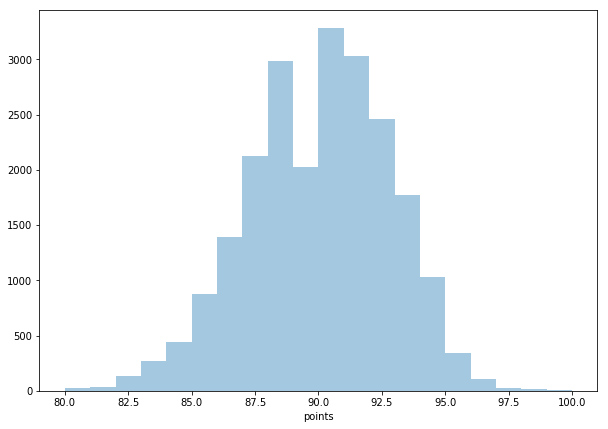

In [21]:
plt.figure(figsize = (10, 7))
sns.distplot(wine['points'], kde = False, bins = 20);

`Price` has many outliers. We can log-transorm it to make it look more akin to a normally-distributed variable, even though it still has a positive skew, due to outliers.

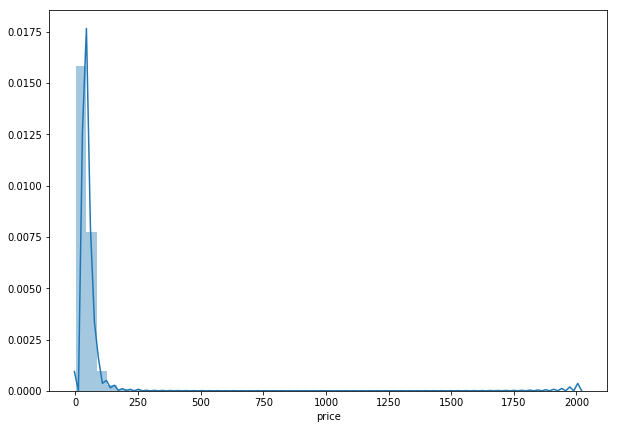

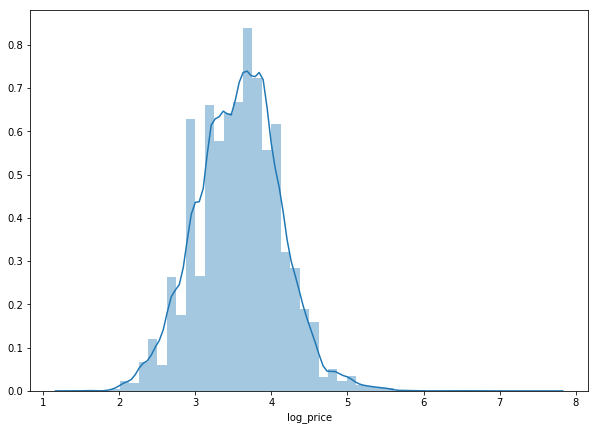

In [24]:
fig, ax = plt.subplots(figsize = (10, 7))
sns.distplot(wine['price'])
ax.set_xlabel('price')
plt.show();

wine['log_price'] = np.log(wine['price'])
fig, ax = plt.subplots(figsize = (10, 7))
sns.distplot(wine['log_price'])
ax.set_xlabel('log_price')
plt.show();

`points` has a much higher Pearson's correlation coefficient with the log-transformed `price` than the unadulterated version. But, interestingly, it's very close to Spearman's rank correlation coefficient, which measures the monotonic relationship bewteen the variables.

In [68]:
wine['points'].corr(price)
wine['points'].corr(log_price)
wine['points'].corr(log_price, method = 'spearman')

0.458233317096922

0.61085211692652686

0.60503815891176693

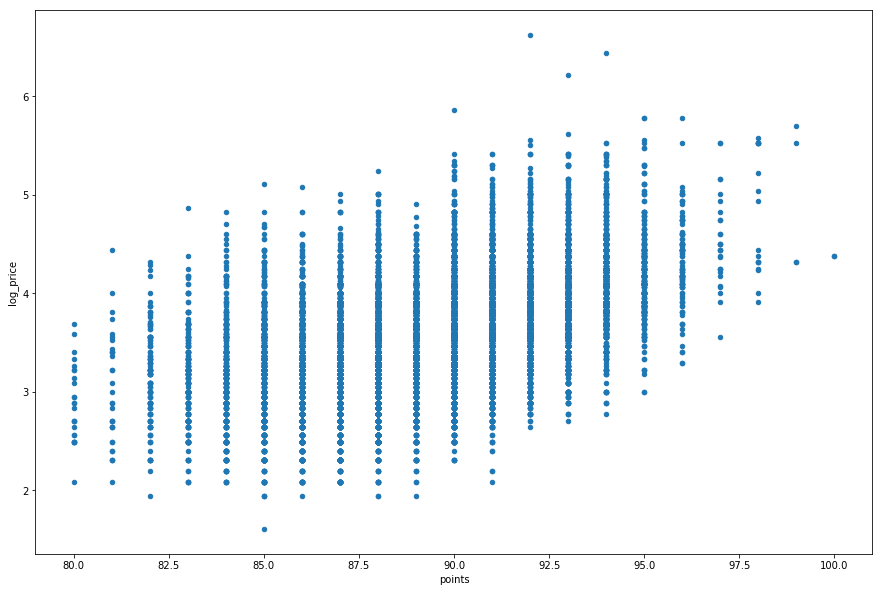

In [108]:
wine = wine.loc[wine['price'] < 1500]
wine.plot.scatter('points', 'log_price', figsize = (15, 10));

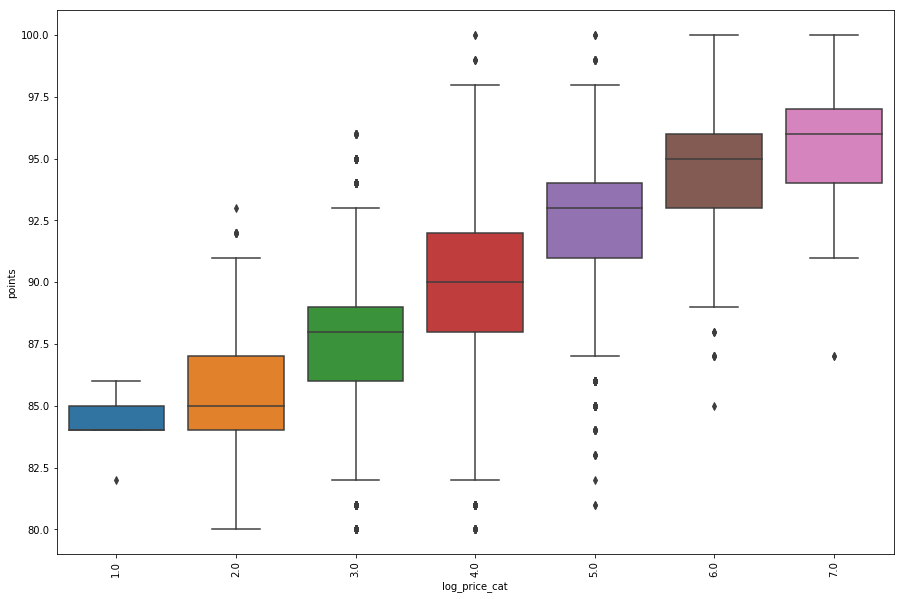

In [72]:
wine['log_price_cat'] = wine['log_price'].round()

fig, ax = plt.subplots(figsize = (15, 10))
sns.boxplot(y = wine['points'], x = wine['log_price_cat'])
plt.xticks(rotation = 90);

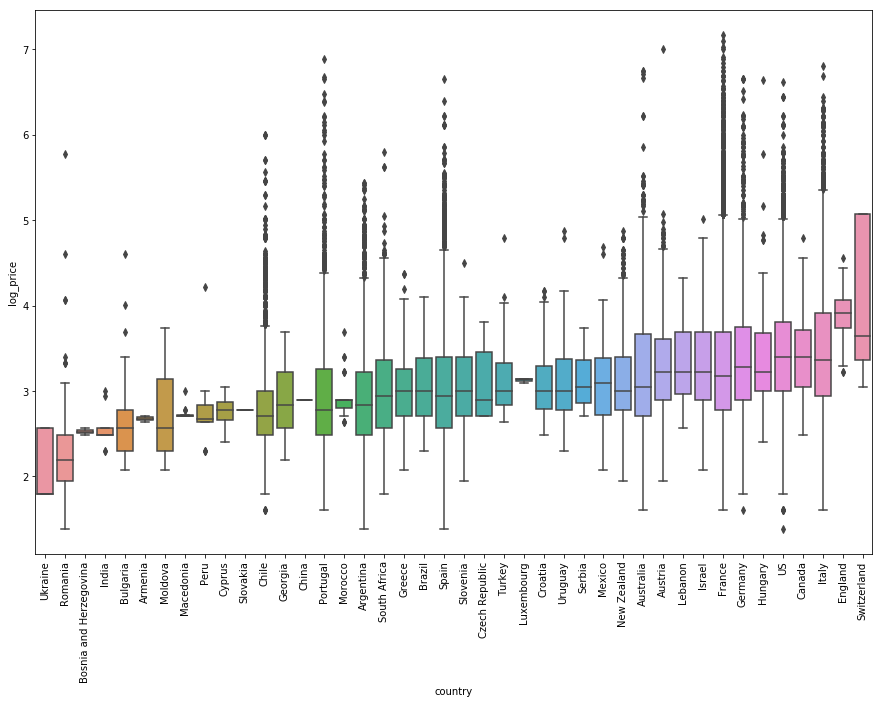

In [90]:
country_means = wine.groupby('country').agg(np.mean).reset_index()

rank_country_price = countries.sort_values('log_price', ascending=1)['country']
fig, ax = plt.subplots(figsize = (15, 10))
sns.boxplot(y = wine['log_price'], x = wine['country'], order=rank_country_price)
plt.xticks(rotation = 90);

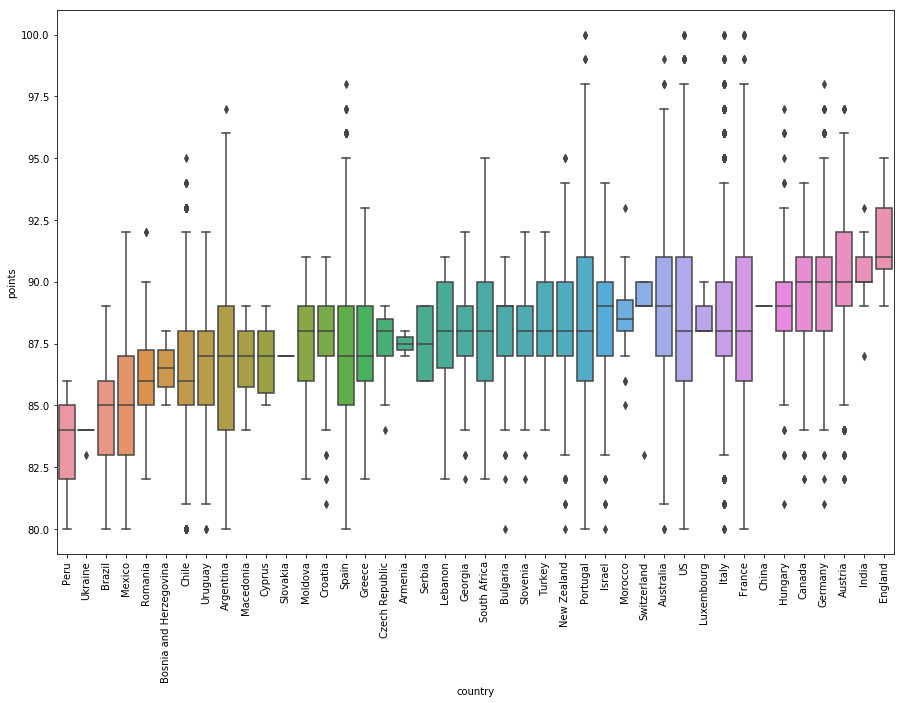

In [94]:
rank_country_points = countries.sort_values('points', ascending=1)['country']

fig, ax = plt.subplots(figsize = (15, 10))
sns.boxplot(y = wine['points'], x = wine['country'], order=rank_country_points)
plt.xticks(rotation = 90);

In [69]:
wine['excellent+'] = np.where(wine['points'] >= 90, 1, 0)

In [70]:
wine.groupby('excellent+').describe()

log_price                                                    \
               count      mean       std       min       25%       50%   
excellent+                                                               
0            72409.0  3.054016  0.530787  1.386294  2.708050  2.995732   
1            44407.0  3.749749  0.599780  1.945910  3.332205  3.688879   

                                 points              ...   price          \
                 75%       max    count       mean   ...     75%     max   
excellent+                                           ...                   
0           3.401197  6.684612  72409.0  86.530072   ...    30.0   800.0   
1           4.094345  7.170120  44407.0  91.599410   ...    60.0  1300.0   

               year                                                         \
              count         mean       std     min     25%     50%     75%   
excellent+                                                                   
0           72409.0  2010.636910  3.730855  1919.0  2009.0  2011.0  2013.0   
1           44407.0  2010.877384  3.752929  1904.0  2009.0  2012.0  2013.0   

                    
               max  
excellent+          
0           2017.0  
1           2017.0  

[2 rows x 32 columns]

In [97]:
counts = wine['excellent+'].value_counts()
counts/counts.sum()

0    0.617523
1    0.382477
Name: excellent+, dtype: float64